In [1]:
# This file contains, in that order: an attempt to compute EROI of biofuels, old code to compute all EROIs, to parse themis, and an analysis of solar CSP, & more
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" # 'last' 'none' ...

import pymrio
from pymrio.core.mriosystem import IOSystem
from pymrio.tools.iometadata import MRIOMetaData
from pymrio.tools.iofunctions import *
import numpy as np
import pandas as pd
import scipy.io
import scipy.sparse as sp 
from scipy.sparse import linalg as spla
import pickle
import time
import matplotlib.pyplot as plt
from openpyxl import load_workbook

## À mettre en ligne quelque part

In [23]:
# erois_prices['eroi']
# erois_prices['eroi'].loc[[('BM', 2050, r, 'Electricity by wind onshore') for s in ['BL', 'BM'] for r in themis['BL'][2050].regions]] < \
# erois_prices['eroi'].loc[[('BL', 2050, r, 'Electricity by wind onshore') for r in themis['BL'][2050].regions]]
for s in ['wind onshore', 'wind offshore', 'solar PV', 'solar CSP', 'gas', 'coal']:
    print('EROI '+s+' BL < BM')
    print('')
    for r in themis['BL'][2050].regions: print(\
        erois_prices['eroi'].loc[('BL', 2050,r,'Electricity by '+s)]<erois_prices['eroi'].loc[('BM', 2050,r,'Electricity by '+s)], 'in', r,)
    print('')
    print('')

EROI wind onshore BL < BM

True in China
True in India
False in OECD Europe
True in OECD North America
False in OECD Pacific
True in Economies in transition
True in Latin America
True in Rest of developing Asia
True in Africa and Middle East


EROI wind offshore BL < BM

True in China
True in India
False in OECD Europe
True in OECD North America
False in OECD Pacific
True in Economies in transition
True in Latin America
True in Rest of developing Asia
True in Africa and Middle East


EROI solar PV BL < BM

True in China
True in India
False in OECD Europe
True in OECD North America
False in OECD Pacific
False in Economies in transition
False in Latin America
True in Rest of developing Asia
False in Africa and Middle East


EROI solar CSP BL < BM

True in China
True in India
False in OECD Europe
True in OECD North America
False in OECD Pacific
True in Economies in transition
True in Latin America
True in Rest of developing Asia
True in Africa and Middle East


EROI gas BL < BM

True in C

In [24]:
# Because of mix AND techno ! (with constant mix, EROI: 8 -> 7.8, cf. combo 2050 => proves that change comes from change in techno)
# is it because of change in mix? no, putting 2050 mix in 2010 doesn't have any effect (both are very similar)
mix2050techno2010 = themis['BL'][2010].copy(new_name='THEMIS')
global_mix = themis['BL'][2050].mix_matrix(global_mix = False)
mix2050techno2010.change_mix(global_mix = global_mix, year = 2050, only_exiobase = False)
mix2050techno2010.erois()

<44046x44046 sparse matrix of type '<class 'numpy.float64'>'
	with 1940609 stored elements in Compressed Sparse Column format>

wind onshore      9.4
wind offshore     9.3
solar PV          9.2
coal             12.6
oil               8.2
gas              13.7
nuclear          10.4
hydro            13.1
coal w CCS        NaN
gas w CCS         NaN
biomass&Waste    11.3
biomass w CCS     NaN
ocean             5.5
geothermal        5.3
solar CSP        21.5
total             8.0
dtype: float64

In [25]:
# is it because change in regional shares? not only, because there are decreases (due to techno) in many region-sector, but this probably explain 7.8 -> 7.2
why_eroi_BL_decrease = pd.DataFrame(index = \
    pd.MultiIndex.from_product([themis['BL'][2010].regions, themis['BL'][2010].energy_sectors('electricities')], names=['region', 'sector']))
why_eroi_BL_decrease[2010] = erois_prices['eroi'].loc[('BL', 2010)]
why_eroi_BL_decrease[2050] = erois_prices['eroi'].loc[('BL', 2050)]
why_eroi_BL_decrease

2010  2050
region                  sector                                  
China                   Electricity by wind onshore    6.9   6.9
                        Electricity by wind offshore   NaN   6.9
                        Electricity by solar PV        7.9   7.8
                        Electricity by coal            9.2     9
                        Electricity by oil             5.2   5.1
                        Electricity by gas              18  17.8
                        Electricity by nuclear         6.8   6.7
                        Electricity by hydro           6.9   6.8
                        Electricity by coal w CCS      NaN   5.8
                        Electricity by gas w CCS       NaN   NaN
                        Electricity by biomass&Waste   7.1   7.1
                        Electricity by biomass w CCS   NaN   NaN
                        Electricity by ocean           NaN   inf
                        Electricity by geothermal      NaN   inf
                        Electricity by solar CSP       NaN   8.6
India                   Electricity by wind onshore      8     8
                        Electricity by wind offshore     8     8
                        Electricity by solar PV          8     8
                        Electricity by coal           12.5  12.5
                        Electricity by oil             4.4   4.4
                        Electricity by gas            16.3  16.3
                        Electricity by nuclear         8.3   8.3
                        Electricity by hydro             8     8
                        Electricity by coal w CCS      NaN   6.4
                        Electricity by gas w CCS       NaN   7.6
                        Electricity by biomass&Waste   7.2   7.2
                        Electricity by biomass w CCS   NaN   NaN
                        Electricity by ocean           NaN   inf
                        Electricity by geothermal      NaN   inf
                        Electricity by solar CSP       NaN   5.8
...                                                    ...   ...
Rest of developing Asia Electricity by wind onshore    5.6   3.5
                        Electricity by wind offshore   NaN   3.5
                        Electricity by solar PV        6.7   3.7
                        Electricity by coal           16.1  16.1
                        Electricity by oil             7.4   7.9
                        Electricity by gas            20.5  20.7
                        Electricity by nuclear         9.8   3.4
                        Electricity by hydro           9.8   9.4
                        Electricity by coal w CCS      NaN   6.4
                        Electricity by gas w CCS       NaN   7.6
                        Electricity by biomass&Waste   7.5   3.7
                        Electricity by biomass w CCS   NaN   NaN
                        Electricity by ocean           NaN   4.7
                        Electricity by geothermal      3.3   5.2
                        Electricity by solar CSP       NaN   5.7
Africa and Middle East  Electricity by wind onshore    0.7   1.9
                        Electricity by wind offshore   NaN   1.9
                        Electricity by solar PV        6.5   2.4
                        Electricity by coal           21.1  10.1
                        Electricity by oil             6.6  10.2
                        Electricity by gas            14.8  14.1
                        Electricity by nuclear        13.2   2.4
                        Electricity by hydro           5.7   6.9
                        Electricity by coal w CCS      NaN   4.4
                        Electricity by gas w CCS       NaN   5.7
                        Electricity by biomass&Waste   2.2   1.1
                        Electricity by biomass w CCS   NaN   NaN
                        Electricity by ocean           NaN  11.7
                        Electricity by geothermal      1.7   1.1
                        

In [21]:
import statsmodels.api as sm
loglog = sm.OLS(np.log10(p), sm.add_constant(np.log10(EROI))).fit()
print(loglog.summary())
inv = sm.OLS(p, sm.add_constant(1/EROI)).fit()
print(inv.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.543
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     121.3
Date:                Wed, 28 Nov 2018   Prob (F-statistic):           4.64e-19
Time:                        00:58:27   Log-Likelihood:                 50.184
No. Observations:                 104   AIC:                            -96.37
Df Residuals:                     102   BIC:                            -91.08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8728      0.044     42.509      0.0

In [167]:
10**reg_log.predict(np.log10(np.array([[6], [6.5], [7], [7.5], [8]])))
reg_inv.predict(1/np.array([[6], [6.5], [7], [7.5], [8]]))

array([33.98317118, 32.79727428, 31.73623231, 30.7793032 , 29.91029259])

array([36.12597567, 34.42029945, 32.95829126, 31.69121749, 30.58252795])

In [177]:
len(themis['BL'][2010].regions)

9

## Why EROI decreases in BL

In [ ]:
# Because of mix AND techno ! (with constant mix, EROI: 8 -> 7.8, cf. combo 2050 => proves that change comes from change in techno)
# is it because of change in mix? no, putting 2050 mix in 2010 doesn't have any effect (both are very similar)
mix2050techno2010 = themis['BL'][2010].copy(new_name='THEMIS')
global_mix = themis['BL'][2050].mix_matrix(global_mix = False)
mix2050techno2010.change_mix(global_mix = global_mix, year = 2050, only_exiobase = False)
mix2050techno2010.erois()
# is it because change in regional shares? not only, because there are decreases (due to techno) in many region-sector, but this probably explain 7.8 -> 7.2
why_eroi_BL_decrease = pd.DataFrame(index = \
    pd.MultiIndex.from_product([themis['BL'][2010].regions, themis['BL'][2010].energy_sectors('electricities')], names=['region', 'sector']))
why_eroi_BL_decrease[2010] = erois_prices['eroi'].loc[('BL', 2010)]
why_eroi_BL_decrease[2050] = erois_prices['eroi'].loc[('BL', 2050)]
why_eroi_BL_decrease

## Proportion of energy required to build electricity technos coming from fossils

In [19]:
themis['ADV'][2050].energy_required(themis['ADV'][2050].energy_sectors('electricities'), source='secondary_fuels')\
    /themis['ADV'][2050].energy_required(themis['ADV'][2050].energy_sectors('electricities'))
for sec in themis['ADV'][2050].energy_sectors('electricities'):
    print(sec, round(themis['ADV'][2050].energy_required(sec, source='secondary_fuels')/themis['ADV'][2050].energy_required(sec),2)) # proportion of fossils: 80%

0.7973950751078206

Electricity by wind onshore 0.81
Electricity by wind offshore 0.79
Electricity by solar PV 0.81
Electricity by coal 0.38
Electricity by oil nan
Electricity by gas nan
Electricity by nuclear nan
Electricity by hydro 0.73
Electricity by coal w CCS nan
Electricity by gas w CCS nan
Electricity by biomass&Waste 0.75
Electricity by biomass w CCS nan
Electricity by ocean 0.78
Electricity by geothermal 0.77
Electricity by solar CSP 0.81


## EROI of biofuels

In [5]:
scenarios = ['BL', 'BM']
years = [2010, 2030, 2050]
EROIs = dict()
for techno in ['Biodiesels', 'Biogas', 'Other Liquid Biofuels']: # Biodiesels 1.3; Biogas 2.7; Biofuel 2.3
    EROIs[techno] = dict()
    for scenario in scenarios:
        EROIs[techno][scenario] = dict()
        for year in years: 
            EROIs[techno][scenario][year] = themis[scenario][year].neer(techno) # 1.3 Doesn't work if unitary_themis = True in production (then neer=0/0)
EROIs

NameError: name 'themis' is not defined

## generic functions

In [ ]:
# @property
# def secondary_energy_supply(self):
#     '''
#     Returns the vector of secondary energy supply per unit of product.
#     '''
#     if self.name=='THEMIS' or self.name=='EXIOBASE': return(self.energy_supply * self.is_in(self.energy_sectors('secondary')))
#     else: return('Property not yet implemented for this IOSystem.')    
    
# @property
# def secondary_fuel_supply(self):
#     '''
#     Returns the vector of secondary fuel supply per unit of product.
#     '''
#     if self.name=='THEMIS' or self.name=='EXIOBASE': return(self.energy_supply * self.is_in(self.energy_sectors('secondary_fuels')))
#     else: return('Property not yet implemented for this IOSystem.')
 
# def energy_requirement(self, secs, regs=None, var='Total Energy supply', partition_sources=['secondary_heats', 'electricities'], netting_fuel=True, decimals=2):
#     '''
#     Returns energy required to produce one unit of energy in sectors secs in regs, decomposed according to the sources in partition_sources.
#     '''
#     er = {}
#     for source in partition_sources:
# #         er[source] = round(1/self.neer(secs = secs, regs = regs, var = var, source = source, netting_fuel = netting_fuel), decimals)
#         er[source] = round(self.energy_required(secs = secs, regs = regs, var = var, source = source, netting_fuel = netting_fuel), decimals)
#     return(er)
   
# def energy_requirements(self, secs=None, var='Total Energy supply', partition_sources=['secondary_heats', 'electricities'], netting_fuel=True, recompute=False):
#     '''
#     Returns the series of energy required of the list of sectors secs, decomposed according to the sources in partition_sources.
#     '''
#     if secs is None: secs = self.energy_sectors('electricities')
#     if recompute or not hasattr(self, 'ers'):
#         ers = pd.DataFrame(columns = partition_sources)
#         for i, sec in enumerate(secs): 
#             er_sec = self.energy_requirement(sec, regs = self.regions, var = var, partition_sources = partition_sources, netting_fuel = netting_fuel)
#             ers = ers.append(pd.Series(er_sec).rename(secs[i][15:]))
#         ers = ers.append(pd.Series(self.energy_requirement([s for s in secs], regs = self.regions, var = var, partition_sources = partition_sources, \
#                                            netting_fuel = netting_fuel)).rename('Power sector'))
#         self.ers = ers.copy()
#     return(self.ers)   

# ## GENERIC FUNCTIONS, used:
# def sorted_series(series): 
#     '''
#     Returns the sorted panda series, grouped by group_by if it is not None, and indexed by index (the default index is that of regions x sectors)
#     '''
#     return(sorted(series.items(), reverse=True, key=operator.itemgetter(1)))

# def approx_solution(A, y, n=10):
#     '''
#     Returns the approximate solution x of the sparse matrix equation: (1-A).x=y, by computing the series of A^k.y, with k<n
#     '''
#     s, x = sp.csc_matrix(y).transpose(), sp.csc_matrix(y).transpose()
#     for i in range(n):
#         x = A.dot(x)
#         s += x
#     return(s)

# def div0(a, b):
#     '''
#     Returns the Hadamard division of the arrays (or matrices) of same shape a and b, where elements of the results are 0 in locations where those of b are 0.
#     '''
#     if type(a)==int or type(a)==float: a = a*np.ones_like(b)
#     a = np.array(a, dtype='float')
#     return(np.divide(a, b, out=np.zeros_like(a), where=b!=0))

# # unused:
# def IOT_from_SUT(S, U, kind='p'):
#     '''
#     Returns the technology matrix Z of kind PxP (by default) or IxI from supply and use tables S and U, by the method of imputation.
#     '''
#     S = np.array(S, dtype='float')
#     if kind=='p' or kind=='P' or kind=='PxP': return(np.transpose(U.dot(div0(S,np.diag(np.sum(S, axis=1)).dot(np.ones(S.shape)))))) #sum(S).ones=sum rows of S
#     elif kind=='i' or kind=='I' or kind=='IxI': return(div0(S,(np.ones(S.shape)).dot(np.diag(np.sum(S, axis=0)))).dot(U)) # ones.sum(S) = sum of columns of S
#     else: print('Wrong kind: set to PxP or IxI')

    
# def global_mix(scenario = 'ER', year = 2050, path_dlr = '/media/adrien/dd1/adrien/DD/Économie/Données/Themis/'):
#     '''
#     Returns an array of global mix (i.e. shares of sec x reg in global total) 
#     for DLR (= Greenpeace) scenario in ['REF', 'ER', 'ADV'] for year in [2010, 2030, 2050]
#     '''
#     dlr_elec = dict()
#     for reg in ['World', 'Africa', 'China', 'Eurasia', 'India', 'Latin America', 'Middle East', \
#                     'OECD Europe', 'OECD North America', 'OECD Asia Oceania', 'O-Asia']:
#         data = pd.read_excel(path_dlr+'Greenpeace_scenarios.xlsx', header=[1], index_col=0, skiprows=[0], skipfooter=144-53, \
#                              sheet_name=scenario+' '+reg, usecols=[1,2,6,10])
#         dlr_elec[reg] = pd.DataFrame(columns = [2012, 2030, 2050])\
#             .append(data.loc[['    - Lignite', '    - Hard coal (& non-renewable waste)']].iloc[[1,3]].sum(axis=0).rename('coal'))\
#             .append(data.loc['    - Gas'].iloc[1].rename('gas')).append(data.loc[['    - Oil', '    - Diesel']].iloc[[1,2]].sum(axis=0).rename('oil'))\
#             .append(data.loc['  - Nuclear'].iloc[0].rename('nuclear')).append(data.loc['    - Biomass (& renewable waste)'].iloc[1].rename('biomass&Waste'))\
#             .append(data.loc['  - Hydro'].rename('hydro')).append(data.loc['of which wind offshore'].rename('wind offshore'))\
#             .append((data.loc['  - Wind']-data.loc['of which wind offshore']).rename('wind onshore'))\
#             .append(data.loc['  - PV'].rename('solar PV')).append(data.loc['    - Geothermal'].iloc[1].rename('geothermal'))\
#             .append(data.loc['  - Solar thermal power plants'].rename('solar CSP')).append(data.loc['  - Ocean energy'].rename('ocean'))\
#             .rename(columns = {2012: 2010})
#     dlr_elec['Africa and Middle East'] = dlr_elec['Africa'] + dlr_elec['Middle East']
#     dlr_elec['OECD Pacific'] = dlr_elec.pop('OECD Asia Oceania')
#     dlr_elec['Rest of developing Asia'] = dlr_elec.pop('O-Asia')
#     dlr_elec['Economies in transition'] = dlr_elec.pop('Eurasia')
#     global_mix = []
#     dlr_sectors = dlr_elec['World'].index
#     themis_BM = themis_parser(path_dlr, year = year, scenario = 'BM')
#     for i in themis_BM.index_secs_regs(['Electricity by ' + s for s in themis_BM.energy_sectors('elecs_names')], themis_BM.regions):
#         sec, reg = themis_BM.labels.idx_sectors[i][15:], themis_BM.labels.idx_regions[i]
#         if sec in dlr_sectors: global_mix = global_mix + [dlr_elec[reg].loc[sec, year]]
#         else: global_mix = global_mix + [0]
#     global_mix = div0(global_mix, np.array(global_mix).sum())
#     return(global_mix)

## old code for EROIs and mixes

In [ ]:
global_mixes_BL = themis['BL'][2010].energy.demand.groupby(level='year', axis=1).sum()
# themis['BL'][2010].global_mixes = round(global_mixes_BL/global_mixes_BL.loc['Electricity by total'],2)
themis['BL'][2010].global_mixes = global_mixes_BL/global_mixes_BL.loc['Electricity by total']
themis['BL'][2010].global_mixes = themis['BL'][2010].global_mixes.rename(index={s: s[15:] for s in themis['BL'][2010].global_mixes.index})
themis['BL'][2010].global_mixes.loc['total']  = global_mixes_BL.loc['Electricity by total']/1000
global_mixes_BM = themis['BM'][2010].energy.demand.groupby(level='year', axis=1).sum()
# themis['BM'][2010].global_mixes = round(global_mixes_BM/global_mixes_BM.loc['Electricity by total'],2)
themis['BM'][2010].global_mixes = global_mixes_BM/global_mixes_BM.loc['Electricity by total']
themis['BM'][2010].global_mixes = themis['BM'][2010].global_mixes.rename(index={s: s[15:] for s in themis['BM'][2010].global_mixes.index})
themis['BM'][2010].global_mixes.loc['total']  = global_mixes_BM.loc['Electricity by total']/1000
print('EROIs of electric technos in 2010:')
pd.DataFrame(themis['BL'][2010].erois(), columns=['EROI']).join(pd.DataFrame(themis['BL'][2010].global_mixes[2010]).rename(columns={2010: 'mix'}))

In [ ]:
dlr = dict()
dlr['EROI'] = dict()
dlr['mix'] = dict()
dlr['mixes'] = dict()
dlr['elec'] = dict()
for scenario in scenarios_dlr:
    dlr['mixes'][scenario] = dict()
    dlr['mix'][scenario] = dict()
    dlr['EROI'][scenario] = dict()
    themis[scenario] = dict()
    for year in years:
        themis[scenario][2050] = themis['BM'][2050].copy(new_name='THEMIS')
        dlr['mixes'][scenario][year] = themis[scenario][2050].mix(scenario = scenario, path_dlr = path_themis)[year]
        dlr['mix'][scenario][year] = (themis[scenario][2050].dlr_elec['World'][year]/themis[scenario][2050].dlr_elec['World'][year].sum())\
            .append(pd.Series({'total': themis[scenario][2050].dlr_elec['World'][year].sum()/1000}))
    dlr['elec'][scenario] = themis[scenario][2050].dlr_elec

In [ ]:
%%capture 
start = time.time() # 22 min
factor = 1
EROIs_mixes = pd.DataFrame(index = themis['BM'][2050].energy_sectors('elecs_names')+['total'])
dlr_sectors = list(np.array(themis['BM'][2050].energy_sectors('electricities'))[['CCS' not in s for s in themis['BM'][2050].energy_sectors('electricities')]])
elec_idx = themis['BM'][2050].index_secs_regs(themis['BM'][2050].energy_sectors('electricities'))
for year in years:    
    for scenario in scenarios_dlr:
        if scenario == 'REF': themis[scenario][year] = themis['BL'][year].copy(new_name='THEMIS')
        else: themis[scenario][year] = themis['BM'][year].copy(new_name='THEMIS') # BM is more efficient: copying from BM in all scenario increases EROI by 0.4
        themis[scenario][year].dlr_elec = dlr['elec'][scenario]
        themis[scenario][year].change_mix(global_mix = dlr['mixes'][scenario][year], year = year, only_exiobase = False)
        dlr['EROI'][scenario][year] = themis[scenario][year].erois(secs = dlr_sectors, factor_elec = factor, recompute=True)
        dlr['EROI'][scenario][year] = dlr['EROI'][scenario][year].rename(index={'Power sector': 'total'})  
        EROIs_mixes[(scenario, year, 'EROI')] = dlr['EROI'][scenario][year]
        EROIs_mixes[(scenario, year, 'mix')] = dlr['mix'][scenario][year]
        EROIs_mixes[(scenario, year, 'price')] = themis[scenario][year].energy_prices()
        EROIs_mixes[(scenario, year, 'employ')] = themis[scenario][year].employments()
        EROIs_mixes[(scenario, year, 'direct_em')] = themis[scenario][year].employments(indirect = False)
    
    for scenario_iea in scenarios: # VERY WEIRD: if I inverse the order of the two 'for' loop, I get slightly different EROIs (this order is the right one)
        erois_s_y = themis[scenario_iea][year].erois(factor_elec = factor, recompute = True)
        erois_s_y = erois_s_y.rename(index={'Power sector': 'total'})
        mixes_s_y = themis[scenario_iea][2010].global_mixes[year]
        EROIs_mixes[[(scenario_iea, year, 'EROI'), (scenario_iea, year, 'mix')]] = pd.DataFrame(erois_s_y).join(mixes_s_y)
        EROIs_mixes[(scenario_iea, year, 'price')] = themis[scenario_iea][year].energy_prices()
        EROIs_mixes[(scenario_iea, year, 'employ')] = themis[scenario_iea][year].employments()
        EROIs_mixes[(scenario_iea, year, 'direct_em')] = themis[scenario_iea][year].employments(indirect = False)
themis['ADV2010'] = themis['BL'][2010].copy(new_name='THEMIS')
themis['ADV2010'].dlr_elec = dlr['elec']['ADV']
themis['ADV2010'].change_mix(global_mix = dlr['mixes']['ADV'][2050], year = 2050, only_exiobase = False)
dlr['EROI']['ADV2010'] = themis['ADV2010'].erois(secs = dlr_sectors, factor_elec = factor, recompute=True)
dlr['EROI']['ADV2010'] = dlr['EROI']['ADV2010'].rename(index={'Power sector': 'total'})  
EROIs_mixes[('ADV2010', 2010, 'EROI')] = dlr['EROI']['ADV2010']
EROIs_mixes[('ADV2010', 2010, 'mix')] = dlr['mix']['ADV'][2050]
EROIs_mixes[('ADV2010', 2010, 'price')] = themis['ADV2010'].energy_prices()
EROIs_mixes[('ADV2010', 2010, 'employ')] = themis['ADV2010'].employments()
EROIs_mixes[('ADV2010', 2010, 'direct_em')] = themis['ADV2010'].employments(indirect = False)
themis['ER2010'] = themis['BL'][2010].copy(new_name='THEMIS')
themis['ER2010'].dlr_elec = dlr['elec']['ER']
themis['ER2010'].change_mix(global_mix = dlr['mixes']['ER'][2050], year = 2050, only_exiobase = False)
dlr['EROI']['ER2010'] = themis['ER2010'].erois(secs = dlr_sectors, factor_elec = factor, recompute=True)
dlr['EROI']['ER2010'] = dlr['EROI']['ER2010'].rename(index={'Power sector': 'total'})  
EROIs_mixes[('ER2010', 2010, 'EROI')] = dlr['EROI']['ER2010']
EROIs_mixes[('ER2010', 2010, 'mix')] = dlr['mix']['ER'][2050]
EROIs_mixes[('ER2010', 2010, 'price')] = themis['ER2010'].energy_prices()
EROIs_mixes[('ER2010', 2010, 'employ')] = themis['ER2010'].employments()
EROIs_mixes[('ER2010', 2010, 'direct_em')] = themis['ER2010'].employments(indirect = False)
themis['now2050'] = themis['BL'][2050].copy(new_name='THEMIS')
mix_now2050 = themis['BL'][2010].mix_matrix(global_mix = False)
EROIs_mixes[('now2050', 2050, 'mix')] = themis['BL'][2010].aggregate_mix(mix_now2050)
themis['now2050'].change_mix(global_mix = mix_now2050, year = 2010, only_exiobase = False) # TODO: current mix, not DLR
dlr['EROI']['now2050'] = themis['now2050'].erois(secs = dlr_sectors, factor_elec = factor, recompute=True)
dlr['EROI']['now2050'] = dlr['EROI']['now2050'].rename(index={'Power sector': 'total'})  
EROIs_mixes[('now2050', 2050, 'EROI')] = dlr['EROI']['now2050']
EROIs_mixes[('now2050', 2050, 'price')] = themis['now2050'].energy_prices()
EROIs_mixes[('now2050', 2050, 'employ')] = themis['now2050'].employments()
EROIs_mixes[('now2050', 2050, 'direct_em')] = themis['now2050'].employments(indirect = False)
for year in years:
    if year==2010: scenarios_year = ['ADV2010', 'ER2010']
    elif year==2030: scenarios_year = []
    elif year==2050: scenarios_year = ['now2050']
    for scenario in scenarios+scenarios_dlr+scenarios_year:
        EROIs_mixes[(scenario, year, 'price')].at['total'] = EROIs_mixes[(scenario, year, 'price')].loc[themis['BL'][2010].energy_sectors('elecs_names')]\
                .fillna(0).dot(EROIs_mixes[(scenario, year, 'mix')].loc[themis['BL'][2010].energy_sectors('elecs_names')].fillna(0))
        EROIs_mixes[(scenario, year, 'employ')].at['total'] = EROIs_mixes[(scenario, year, 'employ')].loc[themis['BL'][2010].energy_sectors('elecs_names')].sum()
        EROIs_mixes[(scenario, year, 'direct_em')].at['total'] = \
                 EROIs_mixes[(scenario, year, 'direct_em')].loc[themis['BL'][2010].energy_sectors('elecs_names')].sum()
#     EROIs_mixes[[(scenario, year, 'EROI'), (scenario, year, 'mix')]] = pd.DataFrame(dlr['EROI'][scenario][year]).join(dlr['mix'][scenario][year])
# EROIs = pd.DataFrame(EROIs, columns = pd.MultiIndex.from_product([scenarios, years], names=['scenario', 'year']))
EROIs_mixes = pd.DataFrame(EROIs_mixes, columns=pd.MultiIndex.from_product([scenarios+scenarios_dlr+['ADV2010', 'ER2010', 'now2050'], \
                                years, ['EROI', 'mix', 'price', 'employ', 'direct_em']], names=['scenario', 'year', 'var']))

In [ ]:
# Load Greenpeace scenarios TODO: what about CCS?
# Electricity in TWh/a, heat, final & primary demand in PJ/a, co2 in Mt/a
regions_dlr = ['World', 'Africa', 'China', 'Eurasia', 'India', 'Latin America', 'Middle East', 'OECD Europe', 'OECD North America', 'OECD Asia Oceania', 'O-Asia']
years_dlr = [2012, 2030, 2050]
scenarios_dlr = ['REF', 'ER', 'ADV']
nb_cases = len(scenarios_dlr)*len(years_dlr)
dlr_elec = {'total': pd.DataFrame(columns = years_dlr)}
dlr_heat = {'total': pd.DataFrame(columns = years_dlr)}
dlr_primary_demand = {'total': pd.DataFrame(columns = years_dlr)}
multi_index = pd.MultiIndex.from_product([scenarios_dlr, years_dlr], names=['scenario', 'year'])
dlr_final_demand = pd.DataFrame(columns = multi_index)
dlr_co2 = pd.DataFrame(columns = multi_index)
for s in scenarios_dlr:
    dlr_elec[s] = dict()
    dlr_heat[s] = dict()
    dlr_primary_demand[s] = dict()
    for reg in regions_dlr:
        data = pd.read_excel(path_themis+'Greenpeace_scenarios.xlsx', header=[1], index_col=0, skiprows=[0], skipfooter=144-53, \
                             sheet_name=s+' '+reg, usecols=[1,2,6,10])
        dlr_elec['total'] = dlr_elec['total'].append(data.loc['Total generation'].rename(s+' '+reg))
        dlr_elec[s][reg] = pd.DataFrame(columns = years_dlr)\
            .append(data.loc[['    - Lignite', '    - Hard coal (& non-renewable waste)']].iloc[[1,3]].sum(axis=0).rename('coal'))\
            .append(data.loc['    - Gas'].iloc[1].rename('gas')).append(data.loc[['    - Oil', '    - Diesel']].iloc[[1,2]].sum(axis=0).rename('oil'))\
            .append(data.loc['  - Nuclear'].iloc[0].rename('nuclear')).append(data.loc['    - Biomass (& renewable waste)'].iloc[1].rename('biomass&Waste'))\
            .append(data.loc['  - Hydro'].rename('hydro')).append(data.loc['of which wind offshore'].rename('wind offshore'))\
            .append((data.loc['  - Wind']-data.loc['of which wind offshore']).rename('wind onshore'))\
            .append(data.loc['  - PV'].rename('solar PV')).append(data.loc['    - Geothermal'].iloc[1].rename('geothermal'))\
            .append(data.loc['  - Solar thermal power plants'].rename('solar CSP')).append(data.loc['  - Ocean energy'].rename('ocean'))\
            .rename(columns = {2012: 2010})
        dlr_heat[s][reg] = pd.read_excel(path_themis+'Greenpeace_scenarios.xlsx', header=[0], index_col=0, skiprows=list(range(107)), skipfooter=144-138, \
                             sheet_name=s+' '+reg, usecols=[1,2,6,10])
        dlr_heat['total'] = dlr_elec['total'].append(dlr_heat[s][reg].iloc[22].rename(s+' '+reg))
        dlr_heat[s][reg] = dlr_heat[s][reg].iloc[23:]
        dlr_heat[s][reg] = dlr_heat[s][reg].rename(index = {key: key[4:].lower() for key in dlr_heat[s][reg].index}, columns = {2012: 2010})
        data = pd.read_excel(path_themis+'Greenpeace_scenarios.xlsx', header=[0], index_col=0, skiprows=list(range(29)), skipfooter=144-138, \
                             sheet_name=s+' '+reg, usecols=[12,13,17,21])
        dlr_primary_demand[s][reg] = data.iloc[[95,96,97,99,100,101,102,103,104]].append(data.iloc[[93,94]].sum(axis=0).rename('    - coal'))\
            .rename(columns = {2012: 2010})
        dlr_primary_demand[s][reg]=dlr_primary_demand[s][reg].rename(index={k: k[6:].lower() for k in dlr_primary_demand[s][reg].index})\
            .rename(index={'clear': 'nuclear', 'natural gas': 'gas', 'crude oil': 'oil', 'biomass (& renewable waste)': 'biomass&Waste', 'ocean energy': 'ocean'})
        dlr_primary_demand['total'] = dlr_primary_demand['total'].append(data.iloc[91].rename(s+' '+reg))
        dlr_final_demand.loc[reg, [(s, y) for y in years_dlr]] = np.array(data.loc['Total (incl. non-energy use)'])
        dlr_co2.loc[reg, [(s, y) for y in years_dlr]] = np.array(data.loc['CO2 emissions by sector'])
dlr_heat['total'] = dlr_heat['total'].rename(columns = {2012: 2010})
dlr_elec['total'] = dlr_elec['total'].rename(columns = {2012: 2010})
dlr_primary_demand['total'] = dlr_primary_demand['total'].rename(columns = {2012: 2010})
dlr_final_demand.columns.set_levels([2010, 2030, 2050], level = 1, inplace=True)
dlr_co2.columns.set_levels([2010, 2030, 2050], level = 1, inplace=True)
dlr_h2 = pd.DataFrame(columns = [2010, 2030, 2050])
for s in ['REF', 'ER', 'ADV']: 
    for reg in regions_dlr: dlr_h2 = dlr_h2.append((dlr_elec['total'].loc[s+' '+reg] - dlr_elec[s][reg].sum(axis=0)).rename(s+' '+reg))

In [ ]:
for s in ['REF', 'ER', 'ADV']:
    dlr_elec[s]['Africa and Middle East'] = dlr_elec[s]['Africa'] + dlr_elec[s]['Middle East']
    dlr_heat[s]['Africa and Middle East'] = dlr_heat[s]['Africa'] + dlr_heat[s]['Middle East']
    dlr_primary_demand[s]['Africa and Middle East'] = dlr_primary_demand[s]['Africa'] + dlr_primary_demand[s]['Middle East']
    dlr_elec[s]['OECD Pacific'] = dlr_elec[s].pop('OECD Asia Oceania')
    dlr_heat[s]['OECD Pacific'] = dlr_heat[s].pop('OECD Asia Oceania')
    dlr_primary_demand[s]['OECD Pacific'] = dlr_primary_demand[s].pop('OECD Asia Oceania')
    dlr_elec[s]['Rest of developing Asia'] = dlr_elec[s].pop('O-Asia')
    dlr_heat[s]['Rest of developing Asia'] = dlr_heat[s].pop('O-Asia')
    dlr_primary_demand[s]['Rest of developing Asia'] = dlr_primary_demand[s].pop('O-Asia')
    dlr_elec[s]['Economies in transition'] = dlr_elec[s].pop('Eurasia')
    dlr_heat[s]['Economies in transition'] = dlr_heat[s].pop('Eurasia')
    dlr_primary_demand[s]['Economies in transition'] = dlr_primary_demand[s].pop('Eurasia')
dlr_final_demand.loc['Africa and Middle East'] = dlr_final_demand.loc['Africa']+dlr_final_demand.loc['Middle East']
dlr_co2.loc['Africa and Middle East'] = dlr_co2.loc['Africa']+dlr_co2.loc['Middle East']
dlr_co2 = dlr_co2.rename(index = {'OECD Asia Oceania': 'OECD Pacific', 'O-Asia': 'Rest of developing Asia', 'Eurasia': 'Economies in transition'})
dlr_final_demand = dlr_final_demand.rename(index = {'OECD Asia Oceania': 'OECD Pacific', 'O-Asia': 'Rest of developing Asia', \
                                                    'Eurasia': 'Economies in transition'})
regions_dlr = set(regions_dlr + list(themis['BL'][2010].regions))

In [ ]:
dlr_mix = dict()
for scenario in ['REF', 'ER', 'ADV']:
    dlr_mix[scenario] = dict()
    for year in [2010, 2030, 2050]:
        dlr_mix[scenario][year] = []
        dlr_sectors = dlr_elec['ER']['World'].index
        for i in themis['BM'][2050].index_secs_regs(['Electricity by ' + s for s in themis['BM'][2050].energy_sectors('elecs_names')], \
                                                    themis['BM'][2050].regions):
            sec, reg = themis['BM'][2050].labels.idx_sectors[i][15:], themis['BM'][2050].labels.idx_regions[i]
            if sec in dlr_sectors: dlr_mix[scenario][year] = dlr_mix[scenario][year] + [dlr_elec[scenario][reg].loc[sec, year]]
            else: dlr_mix[scenario][year] = dlr_mix[scenario][year] + [0]
        dlr_mix[scenario][year] = div0(dlr_mix[scenario][year], np.array(dlr_mix[scenario][year]).sum())

In [26]:
# themis['BM'][2050].energy_sectors('elecs_names')
# dlr_elec['ER']['World'] # TODO: hydrogen

In [57]:
# pickle.dump({'dlr_elec': dlr_elec, 'dlr_heat': dlr_heat, 'dlr_co2': dlr_co2, 'dlr_h2': dlr_h2, 'dlr_primary_demand': dlr_primary_demand,
#             'dlr_final_demand': dlr_final_demand, 'regions_dlr': regions_dlr}, open(path_themis+'greenpeace_scenarios.pkl', 'wb'))
pickle.dump((dlr_elec, dlr_heat, dlr_primary_demand, dlr_co2, dlr_h2, dlr_final_demand, regions_dlr, dlr_mix), open(path_themis+'greenpeace_scenarios.pkl', 'wb'))

## Regression p ~ EROI

In [163]:
# REGRESSIONS price ~ EROI
# N = 1953, Inv regression: p = 18 + 85/EROI (R^2=0.54); log regression: p = 100·EROI^-0.57 (R^2=0.57)

# Preparation
EROI_for_prediction = np.array([i/100 for i in range(1,10000)], ndmin=2, dtype=float).transpose()
inv_EROI_for_prediction = 1/EROI_for_prediction
log_EROI_for_prediction = np.log10(EROI_for_prediction)
erois = np.array(erois_prices['eroi']) # erois_prices_wo_GW yield almost same results
prices = np.array(erois_prices['price']) 
erois_cleaned = erois[np.logical_not(np.logical_or(pd.isnull(erois), pd.isnull(prices)))]
prices_cleaned = prices[np.logical_not(np.logical_or(pd.isnull(erois), pd.isnull(prices)))]
EROI_ = np.array(erois_cleaned[np.logical_not(np.isposinf(np.array(erois_cleaned, dtype=float)))], ndmin=2, dtype=float).transpose()
p_ = prices_cleaned[np.logical_not(np.isposinf(np.array(erois_cleaned, dtype=float)))]
EROI = np.array([EROI_[i] for i, x in enumerate(p_) if EROI_[i]>0 and x>0])
p = np.array([x for i, x in enumerate(p_) if EROI_[i]>0 and x>0])

# Inv regression
reg_inv = LinearRegression().fit(1/EROI, p)  # R^2: 0.54 ; p = 18 + 85/EROI
print('R^2 inv:', round(reg_inv.score(1/EROI, p), 2), '; p =', round(reg_inv.intercept_, 2), '+', round(reg_inv.coef_[0], 2), '/ EROI')
p_predicted = reg_inv.predict(inv_EROI_for_prediction)

# log regression
reg_log = LinearRegression().fit(np.log10(EROI), np.log10(p)) # R^2: 0.61; p = 94 + EROI^-0.57
print('R^2 log:', round(reg_log.score(np.log10(EROI), np.log10(p)), 2), '; p =',round(10**reg_log.intercept_, 2),'· EROI ^',round(reg_log.coef_[0], 2)) 
log_p_predicted = reg_log.predict(log_EROI_for_prediction)

# Both regression explain same share of variance
TSS = sum((p - np.mean(p))**2)
iSS = sum((p - reg_inv.predict(1/EROI))**2)
lSS = sum((p - 10**reg_log.predict(np.log10(EROI)).flatten())**2)
print('"true" R^2 inv:', round(1-iSS/TSS, 2), '; standard-error: ', round(sum((p - reg_inv.predict(1/EROI))**2)**0.5/p.size, 2))
print('"true" R^2 log:', round(1-lSS/TSS, 2), '; standard-error: ', round(sum((p - 10**reg_log.predict(np.log10(EROI)).flatten())**2)**0.5/p.size,2))

R^2 inv: 0.54 ; p = 17.92 + 84.49 / EROI
R^2 log: 0.61 ; p = 94.27 · EROI ^ -0.57
"true" R^2 inv: 0.54 ; standard-error:  0.29
"true" R^2 log: 0.57 ; standard-error:  0.28


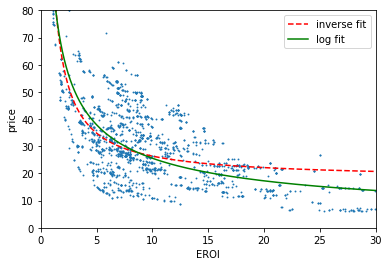

In [159]:
# Both regressions
fig = plt.figure()
ax = plt.subplot(111)
_= plt.scatter(x=EROI, y=p, marker = '.', s = 3)
_= ax.plot(EROI_for_prediction, p_predicted, color='r', linestyle='--', label='inverse fit')
_= ax.plot(EROI_for_prediction, np.power(10, log_p_predicted), color='g', label='log fit')
_= ax.set_xlim(0, 30)
_= ax.set_ylim(0, 80)
_= plt.ylabel('price')
_= plt.xlabel('EROI')
handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles, labels, loc='upper right')
_ = fig.savefig('regression price ~ EROI.png', dpi=200, bbox_inches="tight")

# # Inv regression
# fig = plt.figure()
# ax = plt.subplot(111)
# _= plt.scatter(1/EROI, p, marker='.', s = 5, linestyle='--')
# _= plt.plot(inv_EROI_for_prediction, p_predicted, color='r')
# _= ax.set_xlim(0, 0.4)
# _= ax.set_ylim(0, 70)

# # log regression
# fig = plt.figure()
# ax = plt.subplot(111)
# _= plt.scatter(np.log10(EROI), np.log10(p), marker='.', s = 5)
# _= plt.plot(log_EROI_for_prediction, log_p_predicted, color='g')
# _= ax.set_xlim(.2, 1.8)
# _= ax.set_ylim(0.7, 2)

In [ ]:
# REGRESSIONS price ~ EROI restricted to BL 2010
# N = 104

# Preparation
EROI_for_prediction = np.array([i/100 for i in range(1,10000)], ndmin=2, dtype=float).transpose()
inv_EROI_for_prediction = 1/EROI_for_prediction
log_EROI_for_prediction = np.log10(EROI_for_prediction)
erois = np.array(erois_prices.loc[('BL', 2010)]['eroi']) # erois_prices_wo_GW yield almost same results
prices = np.array(erois_prices.loc[('BL', 2010)]['price']) 
erois_cleaned = erois[np.logical_not(np.logical_or(pd.isnull(erois), pd.isnull(prices)))]
prices_cleaned = prices[np.logical_not(np.logical_or(pd.isnull(erois), pd.isnull(prices)))]
EROI_ = np.array(erois_cleaned[np.logical_not(np.isposinf(np.array(erois_cleaned, dtype=float)))], ndmin=2, dtype=float).transpose()
p_ = prices_cleaned[np.logical_not(np.isposinf(np.array(erois_cleaned, dtype=float)))]
EROI = np.array([EROI_[i] for i, x in enumerate(p_) if EROI_[i]>2.5 and x>0]) # EROI_[i]>2.5
p = np.array([x for i, x in enumerate(p_) if EROI_[i]>2.5 and x>0])

# Inv regression
reg_inv = LinearRegression().fit(1/EROI, p)
print('R^2 inv:', round(reg_inv.score(1/EROI, p), 2), '; p =', round(reg_inv.intercept_, 2), '+', round(reg_inv.coef_[0], 2), '/ EROI')
p_predicted = reg_inv.predict(inv_EROI_for_prediction)

# log regression
reg_log = LinearRegression().fit(np.log10(EROI), np.log10(p))
print('R^2 log:', round(reg_log.score(np.log10(EROI), np.log10(p)), 2), '; p =',round(10**reg_log.intercept_, 2),'· EROI ^',round(reg_log.coef_[0], 2)) 
log_p_predicted = reg_log.predict(log_EROI_for_prediction)

# Both regression explain same share of variance
TSS = sum((p - np.mean(p))**2)
iSS = sum((p - reg_inv.predict(1/EROI))**2)
lSS = sum((p - 10**reg_log.predict(np.log10(EROI)).flatten())**2)
print('"true" R^2 inv:', round(1-iSS/TSS, 2), '; standard-error: ', round(sum((p - reg_inv.predict(1/EROI))**2)**0.5/p.size, 2))
print('"true" R^2 log:', round(1-lSS/TSS, 2), '; standard-error: ', round(sum((p - 10**reg_log.predict(np.log10(EROI)).flatten())**2)**0.5/p.size,2))

# Both regressions
fig = plt.figure()
ax = plt.subplot(111)
_= plt.scatter(x=EROI, y=p, marker = '.', s = 3)
_= ax.plot(EROI_for_prediction, p_predicted, color='r', linestyle='--', label='inverse fit')
_= ax.plot(EROI_for_prediction, np.power(10, log_p_predicted), color='g', label='log fit')
_= ax.set_xlim(0, 30)
_= ax.set_ylim(0, 80)
_= plt.ylabel('price')
_= plt.xlabel('EROI')
handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles, labels, loc='upper right')
# _ = fig.savefig('regression price ~ EROI BL2010.png', dpi=200, bbox_inches="tight")

# The two following fits are not great: one can improve them by restricting p and EROI to EROI[i]>2.5, which excludes 3 cases over 104
#   excluding the 6% of EROI>2.5 in the all scenario-year regression doesn't affect the coefficient of the log regression, it only lower R^2 of the inv reg
# Inv regression
fig = plt.figure()
ax = plt.subplot(111)
_= plt.scatter(1/EROI, p, marker='.', s = 5, linestyle='--')
_= plt.plot(inv_EROI_for_prediction, p_predicted, color='r')
_= ax.set_xlim(0, 0.4)
_= ax.set_ylim(0, 70)

# log regression
fig = plt.figure()
ax = plt.subplot(111)
_= plt.scatter(np.log10(EROI), np.log10(p), marker='.', s = 5)
_= plt.plot(log_EROI_for_prediction, log_p_predicted, color='g')
_= ax.set_xlim(.2, 1.8)
_= ax.set_ylim(0.7, 2)

In [140]:
# REGRESSIONS price ~ EROI

# N = 2111, Inv regression: p = 18 + 85/EROI (R^2=0.54); log regression: log(p) = 2 - 0.57·log(EROI) (R^2=0.61)

# Preparation
EROI_for_prediction = np.array([i/100 for i in range(1,10000)], ndmin=2, dtype=float).transpose()
inv_EROI_for_prediction = 1/EROI_for_prediction
log_EROI_for_prediction = np.log10(EROI_for_prediction)
erois = np.array(erois_prices['eroi']) # erois_prices_wo_GW yield almost same results
prices = np.array(erois_prices['price']) 
erois_cleaned = erois[np.logical_not(np.logical_or(pd.isnull(erois), pd.isnull(prices)))]
prices_cleaned = prices[np.logical_not(np.logical_or(pd.isnull(erois), pd.isnull(prices)))]
EROI = np.array(erois_cleaned[np.logical_not(np.isposinf(np.array(erois_cleaned, dtype=float)))], ndmin=2, dtype=float).transpose()
p = prices_cleaned[np.logical_not(np.isposinf(np.array(erois_cleaned, dtype=float)))]

p_ = p
EROI_ = EROI
p_both = np.array([x for i, x in enumerate(p_) if EROI_[i]>2.5 and x>0])
EROI_both = np.array([EROI_[i] for i, x in enumerate(p_) if EROI_[i]>2.5 and x>0])
# Inv regression
# len([x for i, x in enumerate(p) if EROI[i]>2.5])
# len(EROI)
p_for_inv = [x for i, x in enumerate(p) if EROI[i]>2.5] # p 6% of cases
EROI_inv = div0(1, [x for i, x in enumerate(EROI) if x>2.5]) # div0(1, EROI) 
reg_inv = LinearRegression().fit(EROI_inv, p_for_inv)  # R^2: 0.54 ; p = 18 + 85/EROI
print('R^2 inv:', round(reg_inv.score(EROI_inv, p_for_inv), 2), '; p =', round(reg_inv.intercept_, 2), '+', round(reg_inv.coef_[0], 2), '/ EROI')
p_predicted = reg_inv.predict(inv_EROI_for_prediction)

# log regression
log_EROI = np.log10(np.array([x for i, x in enumerate(EROI) if x>0 and p[i]>0]))
log_p = np.array(np.log10(np.array([x for i, x in enumerate(p) if x>0 and EROI[i]>0], dtype=float)), ndmin=2, dtype=float).transpose()
reg_log = LinearRegression().fit(log_EROI, log_p) # R^2: 0.61; p = 94 + EROI^-0.57
print('R^2 log:', round(reg_log.score(log_EROI, log_p), 2), '; p =',round(10**reg_log.intercept_[0], 2),'· EROI ^',round(reg_log.coef_[0][0], 2)) 
# reg_log.coef_[0] # -0.57
# reg_log.intercept_[0] # 2
log_p_predicted = reg_log.predict(log_EROI_for_prediction)

# Both regression have R^2 of 0.36 +/1 0.01
TSS = sum((p_both - np.mean(p_both))**2)
iSS = sum((p_both - reg_inv.predict(1/EROI_both))**2)
lSS = sum((p_both - 10**reg_log.predict(np.log10(EROI_both)).flatten())**2)

print('"true" R^2 inv:', round(1-iSS/TSS, 4), '; standard-error: ', round(sum((p_both - reg_inv.predict(1/EROI_both))**2)**0.5/p_both.size, 4))
print('"true" R^2 log:', round(1-lSS/TSS, 4), '; standard-error: ', round(sum((p_both-10**reg_log.predict(np.log10(EROI_both)).flatten())**2)**0.5/p_both.size,4))

LinearRegression().fit(np.log10(EROI_both), np.log10(p_both)).score(np.log10(EROI_both), np.log10(p_both))
iSS = sum((p_for_inv - reg_inv.predict(EROI_inv))**2)
lSS = sum((10**log_p - 10**reg_log.predict(log_EROI)).flatten()**2)
print('"true" R^2 inv:', round(1-iSS/sum((np.array(p_for_inv) - np.mean(p_for_inv))**2), 4), '; standard-error: ', \
      round(sum((np.array(p_for_inv) - reg_inv.predict(EROI_inv))**2)**0.5/len(p_for_inv), 4))
print('"true" R^2 log:', round(1-lSS/sum((10**log_p - np.mean(10**log_p))**2), 4), '; standard-error: ', \
      round(sum((10**log_p-10**reg_log.predict(log_EROI)).flatten()**2)**0.5/log_p.size,4))

# reg log, R2 log: 0.61
# reg log, R2 tru: 0.57
# reg both R2 log: 0.57
# reg both R2 tru: 0.37

R^2 inv: 0.37 ; p = 14.28 + 113.64 / EROI
R^2 log: 0.61 ; p = 94.27 · EROI ^ -0.57
"true" R^2 inv: 0.3573 ; standard-error:  0.2432
"true" R^2 log: 0.3702 ; standard-error:  0.2408


0.5627268226805111

"true" R^2 inv: 0.3671 ; standard-error:  0.243
"true" R^2 log: 0.5737 ; standard-error:  0.2809


R^2 inv: 0.41 ; p = 13.95 + 133.04 / EROI
R^2 log: 0.54 ; p = 74.62 · EROI ^ -0.44


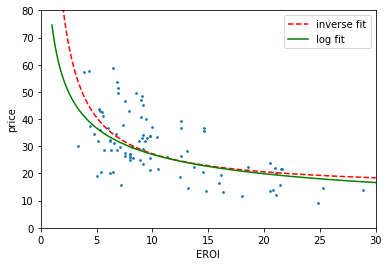

In [170]:
# REGRESSIONS price ~ EROI restricted to BL 2010
# N = 104

# Preparation
EROI_for_prediction = np.array([i/100 for i in range(100,10000)], ndmin=2, dtype=float).transpose()
inv_EROI_for_prediction = 1/EROI_for_prediction
log_EROI_for_prediction = np.log10(EROI_for_prediction)
erois = np.array(erois_prices.loc[('BL', 2010)]['eroi'])
prices = np.array(erois_prices.loc[('BL', 2010)]['price'])
erois_cleaned = erois[np.logical_not(np.logical_or(pd.isnull(erois), pd.isnull(prices)))]
prices_cleaned = prices[np.logical_not(np.logical_or(pd.isnull(erois), pd.isnull(prices)))]
EROI = np.array(erois_cleaned[np.logical_not(np.isposinf(np.array(erois_cleaned, dtype=float)))], ndmin=2, dtype=float).transpose()
p = prices_cleaned[np.logical_not(np.isposinf(np.array(erois_cleaned, dtype=float)))]

# Inv regression
p_for_inv = [x for i, x in enumerate(p) if EROI[i]>2.5] # p 3 cases over 104
EROI_inv = div0(1, [x for i, x in enumerate(EROI) if x>2.5]) # div0(1, EROI) 
reg_inv = LinearRegression().fit(EROI_inv, p_for_inv)
print('R^2 inv:', round(reg_inv.score(EROI_inv, p_for_inv), 2), '; p =', round(reg_inv.intercept_, 2), '+', round(reg_inv.coef_[0], 2), '/ EROI')
p_predicted = reg_inv.predict(inv_EROI_for_prediction)

# log regression
log_EROI = np.log10(np.array([x for i, x in enumerate(EROI) if x>0 and p[i]>0]))
log_p = np.array(np.log10(np.array([x for i, x in enumerate(p) if x>0 and EROI[i]>0], dtype=float)), ndmin=2, dtype=float).transpose()
reg_log = LinearRegression().fit(log_EROI, log_p) # R^2: 0.61; p = 94 + EROI^-0.57
print('R^2 log:', round(reg_log.score(log_EROI, log_p), 2), '; p =',round(10**reg_log.intercept_[0], 2),'· EROI ^',round(reg_log.coef_[0][0], 2)) 
# reg_log.coef_[0] # -0.57
# reg_log.intercept_[0] # 2
log_p_predicted = reg_log.predict(log_EROI_for_prediction)

# Both regressions
fig = plt.figure()
ax = plt.subplot(111)
_= plt.scatter(x=1/EROI_inv, y=p_for_inv, marker = '.', s = 12)
_= ax.plot(EROI_for_prediction, p_predicted, color='r', linestyle='--', label='inverse fit')
_= ax.plot(EROI_for_prediction, np.power(10, log_p_predicted), color='g', label='log fit')
_= ax.set_xlim(0, 30)
_= ax.set_ylim(0, 80)
_= plt.ylabel('price')
_= plt.xlabel('EROI')
handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles, labels, loc='upper right')
_ = fig.savefig('regression price ~ EROI BL2010.png', dpi=200, bbox_inches="tight")

# # Inv regression
# fig = plt.figure()
# ax = plt.subplot(111)
# _= plt.scatter(EROI_inv, p_for_inv, marker='.', s = 20)
# _= plt.plot(inv_EROI_for_prediction, p_predicted, color='r', linestyle='--')
# _= ax.set_xlim(0, 0.3)
# _= ax.set_ylim(0, 70)

# # log regression
# fig = plt.figure()
# ax = plt.subplot(111)
# _= plt.scatter(log_EROI, log_p, marker='.', s = 20)
# _= plt.plot(log_EROI_for_prediction, log_p_predicted, color='g')
# _= ax.set_xlim(.2, 1.8)
# _= ax.set_ylim(0.7, 2)

## old code to parse themis

In [19]:
themis = scipy.io.loadmat(path_themis + 'Data/THEMIS2.mat') # 2 scénarios (BaseLine, BlueMap) and 3 periods (2010, 30, 50)
themis_caracs = scipy.io.loadmat(path_themis + 'Data/Characterization_endpoint2.mat')

In [12]:
label = pd.read_excel(path_themis + 'Data/THEMIS2_labels.xls', header=0)
idx_name = label['Name']
idx_region = label['Region']
regions = idx_region.unique()
label2 = pd.read_excel(path_themis + 'Data/THEMIS2_labels.xls', header=0, sheet_name=2)
idx_impacts = label2['FullName']
label3 = pd.read_excel(path_themis + 'Data/THEMIS2_labels.xls', header=0, sheet_name=3)
idx_caracs = label3['Abbreviation THEMIS']

In [49]:
idx_region.loc[np.where(idx_region=='AME')] = 'Africa and Middle East'
idx_region.loc[np.where(idx_region=='CN')] = 'China'
idx_region.loc[np.where(idx_region=='EIT')] = 'Economies in transition'
idx_region.loc[np.where(idx_region=='IN')] = 'India'
idx_region.loc[np.where(idx_region=='LA')] = 'Latin America'
idx_region.loc[np.where(idx_region=='PAC')] = 'OECD Pacific'
idx_region.loc[np.where(idx_region=='US')] = 'OECD North America'
idx_region.loc[np.where(idx_region=='RER')] = 'OECD Europe'
idx_region.loc[np.where(idx_region=='AS')] = 'Rest of developing Asia'
regions = idx_region.unique()

In [14]:
energy_demand_BL = pd.read_excel(path_themis+'Supplementary info & mixes.xlsx', header=[0,1], index_col=0, skiprows=list(range(6)), skipfooter=67, sheet_name=11)
energy_demand_BM = pd.read_excel(path_themis+'Supplementary info & mixes.xlsx', header=[0,1], index_col=0, skiprows=list(range(52)), skipfooter=21, sheet_name=11)
energy_demand_BL.index = ['Electricity by ' + name[0].lower() + name[1:] for name in list(energy_demand_BL.index)]
energy_demand_BM.index = ['Electricity by ' + name[0].lower() + name[1:] for name in list(energy_demand_BM.index)]

In [20]:
secondary_oil_sectors = ['Motor Gasoline', 'Gas/Diesel Oil', 'Heavy Fuel Oil', 'Kerosene Type Jet Fuel', 'Liquefied Petroleum Gases (LPG)', 'Naphtha', \
                         'Non-specified Petroleum Products', 'Kerosene', 'Petroleum Coke', 'Aviation Gasoline', 'Gasoline Type Jet Fuel']
renewable_wo_hydro = ['Electricity by wind onshore', 'Electricity by wind offshore', 'Electricity by biomass&Waste', 'Electricity by ocean', \
                      'Electricity by geothermal', 'Electricity by solar PV', 'Electricity by solar CSP'] 
renewable_sectors = ['Electricity by hydro'] + renewable_wo_hydro
elec_hydrocarbon = ['Electricity by coal', 'Electricity by gas', 'Electricity by oil']
electricity = renewable_sectors + elec_hydrocarbon + ['Electricity by nuclear']
final_energy_sectors = ['Steam and hot water supply services'] + electricity

secondary_energy_sectors = final_energy_sectors + secondary_oil_sectors
hydrocarbon = ['coal', 'gas', 'oil']
sources = ['wind onshore', 'wind offshore', 'solar PV', 'coal', 'oil', 'gas', 'nuclear', 'hydro', 'coal w CCS', 'gas w CCS', 'biomass&Waste', \
          'biomass w CCS', 'ocean', 'geothermal', 'solar CSP'] #, 'wind']

def sectors_source(source): 
    if source=='secondary': return(secondary_energy_sectors)
    elif source=='secondary_fuels': return(secondary_oil_sectors)
    else: print("source not known (you may add it to the function 'sectors')")

In [21]:
def index_secs(secs, vec_sectors=idx_name): return(np.where(list(map(lambda s: s == secs, vec_sectors)))[0])

def calc_L_from_A(A): 
    if type(A)==scipy.sparse.csc.csc_matrix: return(spla.inv(sp.eye(A.shape[0])-A))
    else: return(pd.DataFrame(np.linalg.inv(np.eye(A.shape[0])-A), index=A.index, columns=A.columns))
    
def load_themis(matrix='L', year=2010, scenario='_BL', path=path_themis, futur=None, sparse=True, themis=None):
    # scenario is _BL or _BM
    if matrix=='S': 
        Sb = load_themis('Sb', year, scenario, path, futur, themis)
        Sf = load_themis('Sf', year, scenario, path, futur, themis)       
        nb_stressors_b = Sb.shape[0] - Sf.shape[0] # check .shape for sparse
        nb_sectors_f = Sf.shape[1]
        res = sp.hstack([sp.vstack([Sf, sp.csc_matrix((nb_stressors_b, nb_sectors_f))]), Sb])
    else:
        if matrix=='L' or matrix=='A': data = 'A'
        elif matrix=='Sb': data = 'S'
        elif matrix=='Sf': data = 'S_f'
        else: data = matrix

        if year is None and scenario is None and futur: year, scenario = '_2050', '_BM'
        elif year is None and scenario is None and not futur: year, scenario = '_2010', '_BL'
        elif year is not None: year = '_' + str(year)
        if data=='S_f': matrix_name = data + scenario
        else: matrix_name = data + year + scenario

        if themis is None: all_data = scipy.io.loadmat(path_themis + 'Data/THEMIS2.mat')
        else: all_data = themis
        if data=='S_f': res = all_data[matrix_name][:,:,2]
        else: res = all_data[matrix_name]
        if themis is None: del(all_data)
        if matrix=='L': res = calc_L_from_A(res)
    if not sparse: return(res.toarray()) # TODO: DataFrame
    else: return(res)
    
def approx_inverse(m, precision=None, nb_iter=10): # computes inverse of 1-m for sparse matrices
    inv = sp.eye(m.shape[0])
    i = 0
    new_term = m
    while (precision is not None and abs(new_term).max() > precision) or (precision is None and i < nb_iter): 
        inv += new_term
        new_term = new_term.dot(m)
        i += 1
    inv += new_term
    return(inv)

def approx_solution(A, y, n=10): # solution x in (1-A).x=y
    s, x = sp.csc_matrix(y).transpose(), sp.csc_matrix(y).transpose()
    for i in range(n):
        x = A.dot(x)
        s += x
    return(s)

def div0(a, b):
    '''
    Returns the Hadamard division of the arrays (or matrices) of same shape a and b, where elements of the results are 0 in locations where those of b are 0.
    '''
    if type(a)==int or type(a)==float: a = a*np.ones_like(b)
    a = np.array(a, dtype='float')
    return(np.divide(a, b, out=np.zeros_like(a), where=b!=0))


def production(secs, futur=False): 
    if type(secs)==str: secs = [secs]
    secs = ['Electricity by ' + s for s in secs]
    if futur: return(final_energy_demand_futur * [s in secs for s in idx_name])
    else: return([s in secs for s in idx_name] * div0(final_energy_demand, energy_supply))
    

def embodied_prod(secs=None, futur=False, matrix='A', y=None, method='cgs'): # solves for x in (I-A).x=y # TODO: modify calls to embodied_prod for all variabl
    if y is None: y = production(secs, futur)
    if futur: m = A_futur
    else: m = A
    if matrix=='L': return(np.dot(m, y))
    elif matrix=='A': return(spla.cgs(sp.eye(m.shape[0])-m, y, approx_solution(m,y).transpose().toarray()[0], tol=1e-7)[0]) # for sparse matrices
#         if method=='series': return(approx_inverse(m, precision=1e3).dot(y))
#         elif method=='lgmres': return(spla.lgmres(sp.eye(m.shape[0])-m, y, tol=1e-7))
#         elif method=='lgmres_guess': 
#             return(spla.lgmres(sp.eye(m.shape[0])-m, y, approx_inverse(m, precision=1e3), tol=1e3))
#         elif method=='spsolve': return(spla.lgmres(sp.eye(m.shape[0])-m, y)) # exact resolution
#         elif method=='cgs': return(spla.cgs(sp.eye(m.shape[0])-m, y, tol=1e-7))
#         elif method=='cgs_guess': 
#             return(spla.cgs(sp.eye(m.shape[0])-m, y, approx_inverse(m, precision=1e3), tol=1e3))
    
def eroi(secs='Electricity by solar PV', futur=False, netting_fuel = True): 
    y = production(secs, futur) # Maybe I should use kron instead of * in production
     # (cf. https://stackoverflow.com/questions/31040188/dot-product-between-1d-numpy-array-and-scipy-sparse-matrix)
    supply = energy_supply.dot(y).sum() # energy_supply * production # impact(name_var('supply'), regs, secs, io=io).sum()
    embodied = (secondary_energy_supply.dot(embodied_prod(secs, futur, y=y) - y)).sum() #embodied_impact(secs,regs,notion,sectors_source(sourc),io=io).sum()
    if ((type(secs)==str and secs in hydrocarbon) or secs==hydrocarbon) and netting_fuel: 
        input_oil = (secondary_oil_supply.dot(A.dot(y))).sum()
    else: input_oil = 0 # We want to include fuels that are used for transportation, not transformed into electricity (this is not secondary anymore)
    return(round(supply/(embodied - input_oil),1))

def erois(futur = False, display = True, netting_fuel = True):
    erois = []
    if display: 
        print('EROI with energy supply from secondary sources at the denominator, unadjusted for growth')
    for secs in sources: 
        eroi_secs = eroi(secs, futur, netting_fuel) # eroi(sectors_source(secs), regions, notion, source, external)
        erois.append(eroi_secs)
        if display: print(secs, eroi_secs)
    return(erois)

In [22]:
# A = themis['A_2010_BL'] #.toarray()
# Sb = themis['S_2010_BL'] #.toarray() # Stressors background
# A_futur = themis['A_2050_BM'] #.toarray()
# Sb_futur = themis['S_2050_BM'] #.toarray()
# Sf = themis['S_f_BL'][:,:,0] # Stressors foreground
# Sf_futur = themis['S_f_BM'][:,:,2]
A = load_themis('A', futur=False, themis=themis)
A_futur = load_themis('A', futur=True, themis=themis)
S = load_themis('S', futur=False, themis=themis)
S_futur = load_themis('S', futur=True, themis=themis)
del(themis)
C = themis_caracs['C_H_CED_22'] # midpoint characterization
C_large = themis_caracs['C_H_CED_large'] # taken by Thomas
C_index = themis_caracs['EP_H_CED_22']
G = themis_caracs['G_H_CED_22'] # endpoint characterization / Thomas takes G_H_CED_woCO2
G_index = themis_caracs['IMP_H_CED_22'] # cf. THEMIS2_labels.xls/C_IMP for more details
mid2end = themis_caracs['mid2end']
del(themis_caracs)
# nb_stressors = Sb.shape[0]
# nb_stressors_f = Sf.shape[0]
# nb_stressors_b = nb_stressors - nb_stressors_f
# nb_sectors_f = Sf.shape[1]
# nb_sectors_b = Sb.shape[1]
nb_regions = 9
nb_sectors = A.shape[0] # = nb_sectors_f + nb_sectors_b

# S = np.concatenate([np.concatenate([Sf, np.zeros((nb_stressors_b, nb_sectors_f))]), Sb], axis=1)
# S_futur = np.concatenate([np.concatenate([Sf_futur, np.zeros((nb_stressors_b, nb_sectors_f))]), Sb_futur], axis=1)
# del(Sb)
# del(Sf)
# del(Sb_futur)
# del(Sf_futur)

In [23]:
TWh2TJ = 3.60 * 1e3
final_energy_demand, final_energy_demand_futur = np.array([0]*A.shape[0]), np.array([0]*A.shape[0]) # sp.csc_matrix((A.shape[0],1))
for name in energy_demand_BL.index: 
    if name in list(idx_name): 
        final_energy_demand[index_secs(name)] = energy_demand_BL[[(reg, 2010) for reg in regions]].loc[name] * TWh2TJ
        final_energy_demand_futur[index_secs(name)] = energy_demand_BM[[(reg, 2050) for reg in regions]].loc[name] * TWh2TJ
# final_energy_demand, final_energy_demand_futur = sp.csc_matrix(final_energy_demand).transpose(), sp.csc_matrix(final_energy_demand_futur).transpose()

In [24]:
energy_supply = ['Energy Carrier Supply' in sector for sector in idx_impacts] * S
secondary_energy_supply = energy_supply * [s in secondary_energy_sectors for s in idx_name]
secondary_oil_supply = energy_supply * [s in secondary_oil_sectors for s in idx_name]

energy_use = ['Energy Carrier Use' in sector for sector in idx_impacts] * S
# energy_supply = (sp.csc_matrix(['Energy Carrier Supply' in sector for sector in idx_impacts]) * S).transpose()
# energy_use = (sp.csc_matrix(['Energy Carrier Use' in sector for sector in idx_impacts]) * S).transpose()
energy_demand = C[np.where(['Cumulative energy demand' in sector for sector in idx_caracs])[0],:]

In [40]:
labels  = scipy.io.loadmat(path_themis + 'labels.mat')
proc    = scipy.io.loadmat(path_themis + 'PROC.mat')
nbs     = scipy.io.loadmat(path_themis + 'nbs2.mat')
# scipy.io.mmwrite('A_2010_BM.mtx', THEMIS2['A_2010_BM'])
# scipy.io.mmwrite('S_2010_BM.mtx', THEMIS2['S_2010_BM'])
# scipy.io.mmwrite('S_f_BM.mtx',scipy.sparse.csc_matrix(THEMIS2['S_f_BM'][:,:,0]))
# scipy.io.mmwrite('C_midpoint.mtx',scipy.sparse.csc_matrix(C['C_H_CED_large']))
# scipy.io.mmwrite('G_endpoint.mtx',scipy.sparse.csc_matrix(C['G_H_CED_woCO2']))

In [93]:
label_Cyril = pd.read_excel(path_themis + 'Data/THEMIS2_labels.xls', header=0, index_col=[0,1,2,3])
def idx_print(mat, index, n): # méthode de Cyril pour afficher les intrants du n-è processus
    print('Below are the direct inputs of Process: '+str(index.iloc[n-1])+'\n------------\n')
    for i,j in enumerate(mat[:,n-1]):
        if j!=0: print(index.iloc[i], j)

# idx_print(A, label_Cyril, 12)

## all sectors that are energy suppliers

In [56]:
themis['BL'][2010].labels.idx_sectors[np.where(themis['BL'][2010].energy_supply!=0)[0]].unique

<bound method Series.unique of 42226                                            Crops nec
42236    Products of forestry, logging and related serv...
42239                                          Coking Coal
42240                                Other Bituminous Coal
42242                                          Patent Fuel
42246    Crude petroleum and services related to crude ...
42247    Natural gas and services related to natural ga...
42248                                  Natural Gas Liquids
42250                             Uranium and thorium ores
42276    Wood and products of wood and cork (except fur...
42278                                                 Pulp
42282                                       Coke Oven Coke
42283                                             Gas Coke
42284                                             Coal Tar
42285                                       Motor Gasoline
42286                                    Aviation Gasoline
42288                    

## a study of EROI of solar CSP

In [66]:
themis['BL'][2050].neer('Electricity by solar CSP')

2.6

In [26]:
# for sec in dlr_sectors:
#     print(sec, themis['REF'][2050].impacts(secs = sec).sum()*1e-6)
EROIs_Mixes = pd.DataFrame(EROIs_mixes.copy(), \
                columns=pd.MultiIndex.from_product([scenarios+scenarios_dlr, years, ['EROI', 'mix', 'mix_real']], names=['scenario', 'year', 'var']))
EROIs_Mixes[[(scenario, year, 'mix') for year in years for scenario in scenarios+scenarios_dlr]] = \
    round(EROIs_Mixes[[(scenario, year, 'mix') for year in years for scenario in scenarios+scenarios_dlr]], 2)
if 'Total (PWh/a)' in EROIs_Mixes.index: EROIs_Mixes = EROIs_Mixes.rename(index={'Total (PWh/a)': 'total'})  
for scenario in scenarios+scenarios_dlr:
    for year in years: 
        EROIs_Mixes[(scenario, year, 'mix_real')] = themis[scenario][year].mix_matrix(themis[scenario][year].energy_sectors('electricities'))

In [274]:
EROI_tot_wo_CSP = dict()
for scenario in scenarios+scenarios_dlr:
    EROI_tot_wo_CSP[scenario] = dict()
    for year in years: 
        EROI_tot_wo_CSP[scenario][year] = themis[scenario][year].neer(dlr_sectors[:11])
EROI_tot_wo_CSP

{'ADV': {2010: 7.8, 2030: 7.4, 2050: 6.4},
 'BL': {2010: 8.0, 2030: 7.4, 2050: 7.2},
 'BM': {2010: 8.0, 2030: 7.5, 2050: 7.6},
 'ER': {2010: 7.8, 2030: 7.4, 2050: 6.4},
 'REF': {2010: 7.8, 2030: 7.5, 2050: 7.2}}

In [8]:
themis['BL'][2010].energy_supply[themis['BL'][2010].index_secs_regs('Motor Gasoline')]
themis['BL'][2010].secondary_energy_demand[themis['BL'][2010].index_secs_regs('Motor Gasoline')]

array([ 77.31076056, 124.60951459,  86.96132357, 168.33521126,
        95.27486614, 201.82871559,  76.99596499, 106.9905137 ,
       231.90331222])

array([0, 0, 0, 0, 0, 0, 0, 0, 0])

In [14]:
themis['BL'][2010].production(secs='Motor Gasoline') # >0 if non_unitary_themis=False, =0 if =True

True

In [125]:
for reg in themis['BM'][2050].regions:
    print(reg, 100/themis['BM'][2050].energy_required('Electricity by solar CSP', reg))

China 11.96079634678254
India 7.5288868662425745
OECD Europe 18.590299466982124
OECD North America 18.60782133032961
OECD Pacific 7.882754280234253
Economies in transition 15.66011869074373
Latin America 56.18774337504652
Rest of developing Asia 7.587827393978348
Africa and Middle East 7.02387540108168


In [101]:
for scenario in scenarios:
    for year in years: 
        CSP['eroi'][scenario][year] = themis[scenario][year].neer('Electricity by solar CSP') 
CSP['eroi']

In [74]:
scenarios = ['BL', 'BM']
years = [2010, 2030, 2050]
CSP = dict()
CSP['required'] = dict()
CSP['demand'] = dict()
CSP['eroi'] = dict()
for scenario in scenarios:
    CSP['required'][scenario] = dict()
    CSP['demand'][scenario] = dict()
    CSP['eroi'][scenario] = dict()
    for year in years: 
        CSP['required'][scenario][year] = themis[scenario][year].energy_required('Electricity by solar CSP') 
        CSP['demand'][scenario][year] = themis[scenario][year].secondary_energy_demand[themis[scenario][year].index_secs_regs('Electricity by solar CSP')].sum()
        CSP['eroi'][scenario][year] = CSP['demand'][scenario][year]/CSP['required'][scenario][year] 
CSP

{'demand': {'BL': {2010: 2450, 2030: 444851, 2050: 1036249},
  'BM': {2010: 2450, 2030: 1934240, 2050: 8959502}},
 'eroi': {'BL': {2010: 20.974276715987944,
   2030: 2.1019185689007807,
   2050: 2.5866419224582278},
  'BM': {2010: 20.974276715987944,
   2030: 5.772625295163216,
   2050: 9.662112035167354}},
 'required': {'BL': {2010: 116.8097490643123,
   2030: 211640.453908088,
   2050: 400615.55911658454},
  'BM': {2010: 116.8097490643123,
   2030: 335071.116017294,
   2050: 927281.9407796089}}}

In [34]:
PWh2TJ = 3.6e6path_io = '/media/adrien/dd1/adrien/DD/Économie/Données/'
t = pickle.load(open(path_io+'Themis/EROIs.pkl', 'rb'))
EROIs_mixes=t['EROIs_mixes']
dlr=t['dlr']
EROIs_Mixes=t['EROIs_Mixes']
EROI_tot_wo_CSP =t['EROI_tot_wo_CSP']

2.4

In [68]:
themis['BL'][2050].secondary_energy_demand[themis['BL'][2050].index_secs_regs('Electricity by solar CSP')].sum()/PWh2TJ
themis['BL'][2050].impacts(secs='Electricity by solar CSP').sum()/PWh2TJ

0.2878469444444444

0.13576722222222223

In [75]:
# EROIs_Mixes.loc['solar CSP'] 
themis['BM'][2050].secondary_energy_demand[themis['BM'][2050].index_secs_regs('Electricity by solar CSP')]/PWh2TJ
themis['BM'][2050].energy_supply[themis['BM'][2050].index_secs_regs('Electricity by solar CSP')] # The bug came from those zeros. TODO!: why so many zeros ??
themis['BL'][2010].energy_supply[themis['BL'][2010].index_secs_regs('Electricity by solar CSP')]

array([0.24137   , 0.50538028, 0.09388111, 0.25687806, 0.0324825 ,
       0.25586278, 0.24050306, 0.01440222, 0.84799056])

array([ 0.        ,  0.        ,  5.06653889, 81.53993581,  2.92301432,
        0.        ,  0.        ,  0.        ,  0.        ])

array([ 0.        ,  0.        , 37.90256253, 93.88174835,  2.27247699,
        0.        ,  0.        ,  0.        ,  0.        ])

In [13]:
for scneario in ['BL','BM']:
    for year in [2010,2030,2050]:
        themis[scneario][year].regions[np.argmax(themis[scneario][year].energy_supply[themis[scneario][year].index_secs_regs('Electricity by solar CSP')])]

'OECD North America'

'OECD North America'

'OECD North America'

'OECD North America'

'OECD North America'

'OECD North America'

In [63]:
themis['BM'][2010].energy.demand.loc['Electricity by solar CSP'][:,2050].sum()/1000
themis['BM'][2050].secondary_energy_demand[themis['BM'][2050].index_secs_regs('Electricity by solar CSP')].sum()/PWh2TJ

2.488751841123984

2.4887505555555554

In [18]:
# themis['BL'][2010].labels.idx_impacts[np.where(['Energy Carrier Supply' in sector for sector in themis['BL'][2010].labels.idx_impacts])[0]]

In [114]:
themis['BL'][2010].energy_supply[themis['BL'][2010].index_secs_regs('Electricity by solar CSP')] # 

array([ 0.        ,  0.        , 37.90256253, 93.88174835,  2.27247699,
        0.        ,  0.        ,  0.        ,  0.        ])

In [115]:
themis['BL'][2010].secondary_energy_demand[themis['BL'][2010].index_secs_regs('Electricity by solar CSP')]

array([   0,    0,   28, 2422,    0,    0,    0,    0,    0])

In [124]:
themis['BL'][2010].energy_supply[themis['BL'][2010].index_secs_regs('Electricity by ocean')]

array([ 0.        ,  0.        , 12.24956764, 21.25563688,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ])

In [30]:
themis['BM'][2050].impact.S.tocsc()[id_thermal,:][:,np.where([dummy_thermal * themis['BM'][2050].impact.S != 0])[1]].A
np.where(themis['BM'][2050].impact.S.tocsc()[id_pv,:][:,np.where([dummy_pv * themis['BM'][2050].impact.S != 0])[1]].A > 1.1e-3)[1]

array([[1.77932843e-07, 5.04105018e+00, 1.02013395e-07, 1.01984186e-07,
        4.95799214e-07, 1.14099593e-07, 8.14590223e+01, 8.96232412e-04,
        9.01044477e-04, 1.00905926e-03, 9.54303267e-04, 3.80082742e-04,
        7.52907088e-08, 4.51855725e-04, 3.71724902e-04, 1.09928448e-07,
        2.92301432e+00, 1.27910940e-06, 2.37767711e-07, 1.18046819e-08,
        2.22131073e-08]])

array([  0,   2,  23,  24,  58,  59,  60,  61,  62,  82, 119, 126, 163])

In [33]:
dummy_pv = ['Energy Carrier Supply' in sector and 'solar photovoltaic' in sector for sector in themis['BM'][2050].labels.idx_impacts]
dummy_thermal = ['Energy Carrier Supply' in sector and 'solar thermal' in sector for sector in themis['BM'][2050].labels.idx_impacts]
id_pv = np.where(dummy_pv)[0]
id_thermal = np.where(dummy_thermal)[0]
# themis['BM'][2050].labels.idx_sectors[np.where([dummy_pv * themis['BM'][2050].impact.S != 0])[1]] # supplied by solar PV but also various sectors
# themis['BM'][2050].labels.idx_sectors[np.where([dummy_thermal * themis['BM'][2050].impact.S != 0])[1]] # supplied by solar CSP but also various sectors (not PV)
np.array(themis['BM'][2050].labels.idx_sectors[np.where([dummy_thermal * themis['BM'][2050].impact.S != 0])[1]])\
    [np.where(themis['BM'][2050].impact.S.tocsc()[id_thermal,:][:,np.where([dummy_thermal * themis['BM'][2050].impact.S != 0])[1]].A > 1e-2)[1]]
# themis['BL'][2010].labels.idx_impacts[id_pv]
# themis['BL'][2010].labels.idx_impacts[id_thermal]

array(['Electricity by solar CSP', 'Electricity by solar CSP',
       'Electricity by solar CSP'], dtype=object)

In [59]:
themis['BL'][2010].impacts(secs='Gas/Diesel Oil') # TODO!: even secondary fuels have no energy supply!! => because secondary_demand is 0 (from IEA)

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
themis['BL'][2010].impacts(secs='Crude petroleum and services related to crude oil extraction, excluding surveying')
themis['BL'][2010].inputs(secs='Electricity by solar CSP') # TODO: gros pb, main inputs of solar CSP are primary fuels, hence not counted in eroi

/home/adrien/anaconda3/lib/python3.5/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


[[('Electricity by solar CSP', 9.0),
  ('   0.72 m2 module                                                        ',
   0.0),
  ('   1.08 m2 module                                                        ',
   0.0),
  ('   1.63 m2 module                                                        ',
   0.0),
  ('   BOS Construction                                                      ',
   0.0)],
 [('Other Bituminous Coal', 0.27597078248600065),
  ('Natural gas and services related to natural gas extraction, excluding surveying',
   0.2731106858652762),
  ('Electrical machinery and apparatus n.e.c.', 0.09875957846173591),
  ('Other business services', 0.09539374659758748),
  ('Financial intermediation services, except insurance and pension funding services',
   0.07266535629068559)],
 [('Other business services', 0.07357099177475433),
  ('Crude petroleum and services related to crude oil extraction, excluding surveying',
   0.061473019195864106),
  ('   Electricity from EX PC power plant    

In [5]:
scenarios = ['BL', 'BM']
years = [2010, 2030, 2050]
CSP = dict()
CSP['EROI'] = dict()
CSP['prod'] = dict()
CSP['supply'] = dict()
CSP['in'] = dict()
for scenario in scenarios:
    CSP['EROI'][scenario] = dict()
    CSP['prod'][scenario] = dict()
    CSP['supply'][scenario] = dict()
    CSP['in'][scenario] = dict()
    for year in years: 
        CSP['EROI'][scenario][year] = dict()  
        CSP['prod'][scenario][year] = dict()  
        CSP['supply'][scenario][year] = dict()  
        CSP['in'][scenario][year] = dict()     
        for reg in themis['BL'][2010].regions:
            if 'OECD' in reg: 
                CSP['EROI'][scenario][year][reg] = themis[scenario][year].neer('Electricity by solar CSP', regs=reg) # nan for all non OECD
                CSP['prod'][scenario][year][reg] = themis[scenario][year].production('Electricity by solar CSP', regs=reg).sum() # nan for all non OECD
                CSP['supply'][scenario][year][reg] = themis[scenario][year].impacts(secs='Electricity by solar CSP', regs=reg)
                CSP['in'][scenario][year][reg] = themis[scenario][year].inputs(secs='Electricity by solar CSP', regs=reg)
CSP # Results slightly higher if unitary_themis = True in production
# In 2010 production essentially in the US, with EROI=22 (Europe: 6), then in 2030 and 2050 essentially outside US, with EROI US: 15, Europe: 0.9, Pacific: 0.3

/home/adrien/anaconda3/lib/python3.5/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/home/adrien/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:346: RuntimeWarning: invalid value encountered in double_scalars


{'EROI': {'BL': {2010: {'OECD Europe': 5.8,
    'OECD North America': 21.6,
    'OECD Pacific': nan},
   2030: {'OECD Europe': 0.9, 'OECD North America': 14.4, 'OECD Pacific': 0.3},
   2050: {'OECD Europe': 0.9,
    'OECD North America': 14.4,
    'OECD Pacific': 0.3}},
  'BM': {2010: {'OECD Europe': 5.8,
    'OECD North America': 21.6,
    'OECD Pacific': nan},
   2030: {'OECD Europe': 0.9, 'OECD North America': 14.8, 'OECD Pacific': 0.2},
   2050: {'OECD Europe': 0.9,
    'OECD North America': 15.2,
    'OECD Pacific': 0.2}}},
 'in': {'BL': {2010: {'OECD Europe': [[('Electricity by solar CSP', True),
      ('   0.72 m2 module                                                        ',
       False),
      ('   1.08 m2 module                                                        ',
       False),
      ('   1.63 m2 module                                                        ',
       False),
      ('   BOS Construction                                                      ',
       Fa

In [123]:
# InteractiveShell.ast_node_interactivity = 'last'
# themis['ER'] = dict()
# EROIs_dlr_ER = dict()
# for year in [2010, 2030, 2050]:
#     themis['ER'][year] = themis['BM'][year].copy(new_name='THEMIS')
#     themis['ER'][year].change_mix(path_dlr = path_themis, year = year)
#     dlr_ER_sectors = np.array(themis['ER'][year].energy_sectors('electricities'))[['CCS' not in s and 'nuclear' not in s \
#                                                                                  for s in themis['ER'][year].energy_sectors('electricities')]]
#     EROIs_dlr_ER[year] = themis['ER'][year].erois(secs = dlr_ER_sectors)
# pd.DataFrame(EROIs_dlr_ER[year], columns = ['EROI']).join(pd.DataFrame(world_mix_ER[year]).rename(columns={2050: 'mix'}))

In [ ]:
# InteractiveShell.ast_node_interactivity = 'last'
# elec_idx = themis['BM'][2050].index_secs_regs(themis['BM'][2050].energy_sectors('electricities'))
# themis_dlr_ER_2050 = themis['BM'][2050].copy(new_name='THEMIS')
# themis_dlr_ER_2050.change_mix(dlr_mix['ER'][2050])
# dlr_ER50_sectors = np.array(themis_dlr_ER_2050.energy_sectors('electricities'))[['CCS' not in s and 'nuclear' not in s \
#                                                                                  for s in themis_dlr_ER_2050.energy_sectors('electricities')]]
# EROIs_dlr_ER_2050 = themis_dlr_ER_2050.erois(secs = dlr_ER50_sectors)

In [ ]:
# dlr_mix = dict()
# for scenario in ['REF', 'ER', 'ADV']:
#     dlr_mix[scenario] = dict()
#     for year in [2010, 2030, 2050]:
#         dlr_mix[scenario][year] = []
#         dlr_sectors = dlr_elec['ER']['World'].index
#         for i in themis['BM'][2050].index_secs_regs(['Electricity by ' + s for s in themis['BM'][2050].energy_sectors('elecs_names')], \
#                                                     themis['BM'][2050].regions):
#             sec, reg = themis['BM'][2050].labels.idx_sectors[i][15:], themis['BM'][2050].labels.idx_regions[i]
#             if sec in dlr_sectors: dlr_mix[scenario][year] = dlr_mix[scenario][year] + [dlr_elec[scenario][reg].loc[sec, year]]
#             else: dlr_mix[scenario][year] = dlr_mix[scenario][year] + [0]
#         dlr_mix[scenario][year] = div0(dlr_mix[scenario][year], np.array(dlr_mix[scenario][year]).sum())

In [66]:
# def max_gap(a, b): return(np.max(div0(np.abs(a-b), a)))
# def mult_cols(matrix, vector): 
#     '''
#     Multiply (each element of) the k-th column of matrix by k-th element of vector for all k, returns the resulting matrix.
#     Doesn't work for sparse matrix.
#     '''
#     if sp.issparse(matrix): matrix = matrix.toarray()
#     return(matrix * (np.ones(matrix.shape)).dot(np.diag(vector)))
# elec_idx = themis_dlr_ER_2050.index_secs_regs(themis_dlr_ER_2050.energy_sectors('electricities'))
# energy_matrix = mult_cols(themis['BM'][2050].A[:,elec_idx].toarray(), themis_dlr_ER_2050.energy_supply[elec_idx])
# energy_matrix_new = mult_cols(themis_dlr_ER_2050.A[:,elec_idx].toarray(), themis_dlr_ER_2050.energy_supply[elec_idx])
# max_gap(energy_matrix.sum(axis=1), energy_matrix_new.sum(axis=1))

In [ ]:
# world_elec_ER = pd.DataFrame(columns = [2012, 2030, 2050])
# data = pd.read_excel(path_themis+'Greenpeace_scenarios.xlsx', header=[1], index_col=0, skiprows=[0], skipfooter=144-53, \
#                      sheet_name='ER World', usecols=[1,2,6,10])
# world_elec_ER = pd.DataFrame(columns = [2012, 2030, 2050])\
#     .append(data.loc[['    - Lignite', '    - Hard coal (& non-renewable waste)']].iloc[[1,3]].sum(axis=0).rename('coal'))\
#     .append(data.loc['    - Gas'].iloc[1].rename('gas')).append(data.loc[['    - Oil', '    - Diesel']].iloc[[1,2]].sum(axis=0).rename('oil'))\
#     .append(data.loc['  - Nuclear'].iloc[0].rename('nuclear')).append(data.loc['    - Biomass (& renewable waste)'].iloc[1].rename('biomass&Waste'))\
#     .append(data.loc['  - Hydro'].rename('hydro')).append(data.loc['of which wind offshore'].rename('wind offshore'))\
#     .append((data.loc['  - Wind']-data.loc['of which wind offshore']).rename('wind onshore'))\
#     .append(data.loc['  - PV'].rename('solar PV')).append(data.loc['    - Geothermal'].iloc[1].rename('geothermal'))\
#     .append(data.loc['  - Solar thermal power plants'].rename('solar CSP')).append(data.loc['  - Ocean energy'].rename('ocean'))\
#     .rename(columns = {2012: 2010})
# # world_mix_ER_2050 = round(world_elec_ER[2050]/world_elec_ER[2050].sum(),2).set_value('Power sector', 1)
# world_mix_ER = (world_elec_ER/world_elec_ER.sum(axis=0)).append(pd.Series(world_elec_ER.sum(axis=0)).rename('total'))
# # world_mix_ER = (world_elec_ER/world_elec_ER.sum(axis=0)).append(pd.Series({2010: 1.0, 2030: 1.0, 2050: 1.0}).rename('total'))
# # world_mix_ER = round(world_elec_ER/world_elec_ER.sum(axis=0), 2).append(pd.Series({2010: 1.0, 2030: 1.0, 2050: 1.0}).rename('total'))

# dlr = dict()
# scenarios_dlr = ['REF', 'ER', 'ADV']
# for scenario in scenarios_dlr:
#     dlr[scenario] = dict()
#     dlr[scenario]['elec'] = pd.DataFrame(columns = [2012, 2030, 2050])
#     data = pd.read_excel(path_themis+'Greenpeace_scenarios.xlsx', header=[1], index_col=0, skiprows=[0], skipfooter=144-53, \
#                      sheet_name=scenario+' World', usecols=[1,2,6,10])
#     dlr[scenario]['elec'] = pd.DataFrame(columns = [2012, 2030, 2050])\
#         .append(data.loc[['    - Lignite', '    - Hard coal (& non-renewable waste)']].iloc[[1,3]].sum(axis=0).rename('coal'))\
#         .append(data.loc['    - Gas'].iloc[1].rename('gas')).append(data.loc[['    - Oil', '    - Diesel']].iloc[[1,2]].sum(axis=0).rename('oil'))\
#         .append(data.loc['  - Nuclear'].iloc[0].rename('nuclear')).append(data.loc['    - Biomass (& renewable waste)'].iloc[1].rename('biomass&Waste'))\
#         .append(data.loc['  - Hydro'].rename('hydro')).append(data.loc['of which wind offshore'].rename('wind offshore'))\
#         .append((data.loc['  - Wind']-data.loc['of which wind offshore']).rename('wind onshore'))\
#         .append(data.loc['  - PV'].rename('solar PV')).append(data.loc['    - Geothermal'].iloc[1].rename('geothermal'))\
#         .append(data.loc['  - Solar thermal power plants'].rename('solar CSP')).append(data.loc['  - Ocean energy'].rename('ocean'))\
#         .rename(columns = {2012: 2010})
#     dlr[scenario]['mix'] = (dlr[scenario]['elec']/dlr[scenario]['elec'].sum(axis=0)).append(pd.Series(dlr[scenario]['elec'].sum(axis=0)).rename('total'))
#     dlr[scenario]['EROI'] = dict()
#     themis[scenario] = dict()

# EROIs = pd.DataFrame()
# EROIs_mixes = pd.DataFrame()
# scenarios = ['BL', 'BM']
# years = [2010, 2030, 2050]
# themis['ER'] = dict()
# for year in years:
#     for scenario in scenarios:
#         erois_s_y = themis[scenario][year].erois()
#         EROIs[(scenario, year)] = erois_s_y
#         erois_s_y = erois_s_y.rename(index={'Power sector': 'total'})
# #         themis[scenario][year].elec_supply = dict() # commented lines compute mix from IO data directly instead of IEA: similar mixes (+/- 1%) but much longer
# #         themis[scenario][year].elec_mix = dict()
# #         themis[scenario][year].elec_mix['total'] = 1
# #         themis[scenario][year].elec_supply['total'] = themis[scenario][year].energy_supply.dot(\
# #                                                         themis[scenario][year].production(themis[scenario][year].energy_sectors('electricities'))).sum()
# #         for sec in themis[scenario][year].energy_sectors('electricities'):
# #             themis[scenario][year].elec_supply[sec] = themis[scenario][year].energy_supply.dot(themis[scenario][year].production(sec)).sum()
# #             themis[scenario][year].elec_mix[sec[15:]] = round(themis[scenario][year].elec_supply[sec]/themis[scenario][year].elec_supply['total'],2)
# #         themis[scenario][year].elec_mix = pd.DataFrame(pd.Series(themis[scenario][year].elec_mix), columns=['mix'])
# #         mixes_s_y = themis[scenario][year].elec_mix
#         mixes_s_y = themis[scenario][2010].global_mixes[year]
#         EROIs_mixes[[(scenario, year, 'EROI'), (scenario, year, 'mix')]] = pd.DataFrame(erois_s_y).join(mixes_s_y)
#     elec_idx = themis['BM'][year].index_secs_regs(themis['BM'][year].energy_sectors('electricities'))
    
#     themis['ER'][year] = themis['BM'][year].copy(new_name='THEMIS')
#     themis['ER'][year].change_mix(path_dlr = path_themis, year = year)
#     dlr_ER_sectors = np.array(themis['ER'][year].energy_sectors('electricities'))[['CCS' not in s for s in themis['ER'][year].energy_sectors('electricities')]]
#     erois_ER = themis['ER'][year].erois(secs = dlr_ER_sectors, recompute=True)
# #     EROIs[('ER', year)] = erois_ER
#     erois_ER = erois_ER.rename(index={'Power sector': 'total'})  
#     EROIs_mixes[[('ER', year, 'EROI'), ('ER', year, 'mix')]] = pd.DataFrame(erois_ER).join(dlr['mix']['ER'][year])
# # EROIs = pd.DataFrame(EROIs, columns = pd.MultiIndex.from_product([scenarios, years], names=['scenario', 'year']))
# EROIs_mixes = pd.DataFrame(EROIs_mixes, columns = pd.MultiIndex.from_product([scenarios + ['ER'], years, ['EROI', 'mix']], names=['scenario', 'year', 'var']))
# print('EROIs of electric technos in 2050 in the Greenpeace scenario (close to 100% renewable):')
# EROIs_mixes[('ER', 2050)]